In [1]:
from matplotlib.cm import get_cmap
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib as mpl
import sys, os, subprocess
from matplotlib.pyplot import copper, show, xlabel, ylabel
import matplotlib.pyplot as plt
import argparse
from matplotlib.gridspec import GridSpec
import math as math
from scipy.signal import savgol_filter 
import seaborn as sns
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [6]:
def grab_dimTime_particles (dir: str, stat:str, time):
    ts = len(os.listdir(dir))
    for t in range(ts):
        time[t,0] = t
    filt = stat.loc[:,18].notnull()
    time[:,1] = stat[filt].loc[:,1]
    return time

def initial_particle_position (data: str, x: float, y: float):
    rows = []
    for i in range(len(data["initial position:0"])):
        rows.append([math.sqrt(pow((data["initial position:0"][i] - x), 2) + pow((data["initial position:1"][i] - y),2))])
    df = pd.DataFrame(rows, columns=["distance"])
    idx = df["distance"].idxmin()
    return(data["initial position:0"][idx], data["initial position:1"][idx])

def initial_particle_index (data: str, x: float, y: float):
    rows = []
    for i in range(len(data["initial position:0"])):
        rows.append([math.sqrt(pow((data["initial position:0"][i] - x), 2) + pow((data["initial position:1"][i] - y),2))])
    df = pd.DataFrame(rows, columns=["distance"])
    idx = df["distance"].idxmin()
    return(idx)


def load_dataset(loc_data:str, data: str):
    if "initial oc" in data.columns:
        df = pd.read_parquet(loc_data, columns=["initial position:0", "initial position:1", "Points:0", "Points:1", "initial oc"])
    elif {"initial ocean_crust","initial upper_cont","initial lower_cont"}.issubset(data.columns):
        df = pd.read_csv(loc_data, columns=["initial position:0", "initial position:1", "Points:0", "Points:1", "initial ocean_crust","initial upper_cont","initial lower_cont"])
    else:
        df = pd.read_csv(loc_data, columns=["initial position:0", "initial position:1", "Points:0", "Points:1", "initial ocean_crust"])
    return (df)



def get_incoming_particles(data: str, compo: float, from_trench: float, samples: float):
    if "initial oc" in data.columns:
        part = data[(data["initial oc"] >= compo) & (data["Points:0"] <= from_trench + 2.e3) & (data["Points:0"] >= from_trench - 2.e3)]
        part = part.sample(n = samples).reset_index()
    elif {"initial oc","initial sed"}.issubset(data.columns):
        sumcomp = data["initial oc"] + data["initial sed"]
        part = data[(sumcomp >= compo) & (data["Points:0"] <= from_trench + 2.e3) & (data["Points:0"] >= from_trench - 2.e3)]
        part = part.sample(n = samples).reset_index()
    else:
        sumcomp = data["initial oc"] + data["initial serp"]
        part = data[(sumcomp >= compo) & (data["Points:0"] <= from_trench + 2.e3) & (data["Points:0"] >= from_trench - 2.e3)]
        part = part.sample(n = samples).reset_index()
    return (part)

def get_incoming_pos(data: str, compo: float, from_trench: float, samples: float):
    if "initial C_1" in data.columns:
        part = data[(data["initial C_1"] >= compo) & (data["Points:0"] <= from_trench + 2.e3) & (data["Points:0"] >= from_trench - 2.e3)]
        part = part.sample(n = samples).reset_index()
    elif {"initial ocean_crust","initial upper_cont","initial lower_cont"}.issubset(data.columns):
        sumcomp = data["initial ocean_crust"] + data["initial upper_cont"] + data["initial lower_cont"]
        part = data[(sumcomp >= compo) & (data["Points:0"] <= from_trench + 2.e3) & (data["Points:0"] >= from_trench - 2.e3)]
        part = part.sample(n = samples).reset_index()
    else:
        sumcomp = data["initial ocean_crust"]
        part = data[(sumcomp >= compo) & (data["Points:0"] <= from_trench + 2.e3) & (data["Points:0"] >= from_trench - 2.e3)]
        part = part.sample(n = samples).reset_index()
    return (part["initial position:0"], part["initial position:1"])


def get_trench_position(p, threshold = 0.3e7):
    if "oc" in p.columns:
        tr =  p.loc[(p['Points:0']> threshold) & (p['oc'] > 0.3) & (p["Points:1"] >= p["Points:1"].max() - 10.e3),'Points:0'].max()
    elif {"oc","sed"}.issubset(p.columns):
        sumcomp = p["oc"] + p["sed"]
        tr =  p.loc[(p['Points:0']> threshold) & (sumcomp > 0.3) & (p["Points:1"] >= p["Points:1"].max() - 10.e3),'Points:0'].max()
    else:
        sumcomp = p["oc"] + p["serp"]
        tr =  p.loc[(p['Points:0']> threshold) & (sumcomp > 0.3) & (p["Points:1"] >= p["Points:1"].max() - 10.e3),'Points:0'].max()
    return tr


def get_points_with_y_in(data, depth, delta, ymax = 2900.e3): 
    plate_prof_loc = ymax - depth
    within_delta_from_depth = (data['Points:1'] < plate_prof_loc + delta) &(data['Points:1'] > plate_prof_loc - delta)
    return data[within_delta_from_depth].sort_values('Points:0').copy(True)

In [7]:
csvs_loc =  '/home/vturino/PhD/projects/exhumation/gz_outputs/'
models_loc =  '/home/vturino/PhD/projects/exhumation/raw_outputs/'
json_loc = '/home/vturino/PhD/projects/exhumation/pyInput/'
mod = 'kin_CRold.json'

xmax = 5400.e3
zmax = 900.e3

with open(f"{json_loc}{mod}") as json_file:
    configs = json.load(json_file)

m = configs['models'][0]

In [8]:
time_array = np.zeros((len(os.listdir(f"{csvs_loc}{m}/fields")),2))   
stat = pd.read_csv(f"{models_loc}{m}/statistics",skiprows=configs['head_lines'],sep='\s+',header=None)
time_array = grab_dimTime_particles(f"{csvs_loc}{m}/fields", stat, time_array)

In [52]:
def get_incoming_particles(data: str, compo: float, from_trench: float, samples: float):
    if {"initial oc","initial sed"}.issubset(data.columns):
        sumcomp = data["initial oc"] + data["initial sed"]
        part = data[(sumcomp >= compo) & (data["Points:0"] <= from_trench +2.e3)] # & (data["Points:0"] >= from_trench - 2.e3)]
        print(part["Points:0"]/1.e3 - from_trench/1.e3)
        part = part.sample(n = samples).reset_index()
    elif {"initial oc","initial serp"}.issubset(data.columns):
        sumcomp = data["initial oc"] + data["initial serp"]
        part = data[(sumcomp >= compo) & (data["Points:0"] <= from_trench + 1.e3) & (data["Points:0"] >= from_trench - 2.e3)]
        part = part.sample(n = samples).reset_index()
    elif "initial oc" in data.columns:
        part = data[(data["initial oc"] >= compo) & (data["Points:0"] <= from_trench + 2.e3) & (data["Points:0"] >= from_trench - 2.e3)]
        part = part.sample(n = samples).reset_index()
    return (part)

In [56]:
init = pd.read_parquet(f"{csvs_loc}{m}/particles/full.0.gzip")
p = pd.DataFrame(columns=init.columns)

ts = len(time_array)
t = 0

full = pd.read_parquet(f"{csvs_loc}{m}/particles/full.{t}.gzip")
full = full[full["initial position:1"] >= zmax - 12.e3]
data = pd.read_parquet(f"{csvs_loc}{m}/fields/full.{int(t)}.gzip")
pts = get_points_with_y_in(data, 10.e3, 2.e3, ymax = 900.e3)
trench= get_trench_position(pts,threshold = 0.13e7)
print(trench)
incoming = trench - 10.e3
tmp = get_incoming_particles(full, 0.1, incoming, 30)
# p = pd.concat([p,tmp])
tmp

2523437.5
34679     -2466.187988
34680     -2466.551025
34681     -2465.921387
34682     -2465.885986
34683     -2466.106689
              ...     
3035777    -101.426270
3035778    -101.165283
3035779    -101.346191
3035780    -101.153809
3035781    -101.625977
Name: Points:0, Length: 796461, dtype: float32


,index,initial position:0,initial position:1,initial position:2,position:0,position:1,position:2,velocity:0,velocity:1,velocity:2,...,integrated strain_0,integrated strain_1,integrated strain_2,integrated strain_3,integrated strain invariant,p,T,Points:0,Points:1,Points:2
0,315951,5.923114e+04,897647.9375,0.0,5.923114e+04,897647.9375,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,64506448.0,308.389435,5.923114e+04,897647.9375,0.0
1,1803336,2.000610e+06,897533.3750,0.0,2.000610e+06,897533.3750,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,67648464.0,310.112518,2.000610e+06,897533.3750,0.0
2,849493,1.683282e+06,893728.5625,0.0,1.683282e+06,893728.5625,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,171996640.0,367.266602,1.683282e+06,893728.5625,0.0
3,227683,1.787600e+06,893407.3750,0.0,1.787600e+06,893407.3750,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,180805136.0,372.082764,1.787600e+06,893407.3750,0.0
4,2667815,1.259940e+06,891877.1875,0.0,1.259940e+06,891877.1875,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,223500352.0,395.000000,1.259940e+06,891877.1875,0.0
5,2813223,3.308076e+04,892670.3750,0.0,3.308076e+04,892670.3750,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,201016736.0,383.125885,3.308076e+04,892670.3750,0.0
6,1382746,1.851474e+06,892785.1875,0.0,1.851474e+06,892785.1875,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,197867488.0,381.405731,1.851474e+06,892785.1875,0.0
7,1597927,2.490811e+06,896329.3125,0.0,2.490811e+06,896329.3125,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,100669936.0,288.467651,2.490811e+06,896329.3125,0.0
8,425533,2.090980e+06,892442.7500,0.0,2.090980e+06,892442.7500,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,207259488.0,386.534576,2.090980e+06,892442.7500,0.0
9,858534,1.975498e+06,891565.7500,0.0,1.975498e+06,891565.7500,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,232773744.0,399.657928,1.975498e+06,891565.7500,0.0


In [51]:
trench

2550781.2

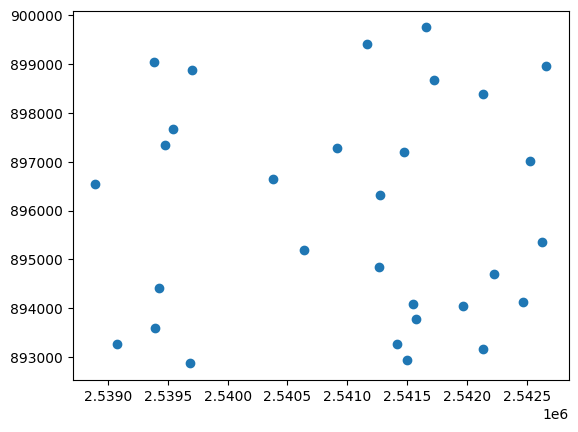

In [52]:
plt.scatter(p["Points:0"], p["Points:1"])

In [6]:
mod = "kinematic_basalt24.8_quartz12.5_oldCR_shifted_DD150km"
gz_loc = f"/home/vturino/PhD/projects/exhumation/gz_outputs/{mod}/particles/"

full = pd.read_parquet(f"{gz_loc}full.23.gzip")
full

,initial position:0,initial position:1,initial position:2,position:0,position:1,position:2,velocity:0,velocity:1,velocity:2,id,...,integrated strain_0,integrated strain_1,integrated strain_2,integrated strain_3,integrated strain invariant,p,T,Points:0,Points:1,Points:2
0,1.498151e+05,23155.074219,0.0,9.346710e+03,22967.617188,0.0,-3.020744e-10,-5.320271e-13,0.0,4404.0,...,1.008206,-0.002060,0.001120,0.991872,0.008188,2.733374e+10,1694.000000,9.346710e+03,22967.617188,0.0
1,1.545174e+05,28696.222656,0.0,1.407426e+04,28470.080078,0.0,-3.019931e-10,-6.386356e-13,0.0,5059.0,...,1.007991,-0.002568,0.001307,0.992088,0.007989,2.716192e+10,1694.000000,1.407426e+04,28470.080078,0.0
2,1.568575e+05,21863.160156,0.0,1.644825e+04,21693.265625,0.0,-3.019090e-10,-4.767670e-13,0.0,4765.0,...,1.007878,-0.001931,0.000955,0.992206,0.007858,2.737338e+10,1694.000000,1.644825e+04,21693.265625,0.0
3,1.495890e+05,25259.945312,0.0,9.114205e+03,25055.113281,0.0,-3.020892e-10,-5.819424e-13,0.0,4391.0,...,1.008220,-0.002256,0.001228,0.991856,0.008207,2.726859e+10,1694.000000,9.114205e+03,25055.113281,0.0
4,1.539151e+05,23500.345703,0.0,1.347920e+04,23314.611328,0.0,-3.019819e-10,-5.240552e-13,0.0,5072.0,...,1.008013,-0.002087,0.001073,0.992069,0.007996,2.732283e+10,1694.000000,1.347920e+04,23314.611328,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196152,5.399952e+06,891484.687500,0.0,5.395328e+06,894288.625000,0.0,-7.224730e-10,-6.925595e-13,0.0,4279718.0,...,1.047126,-0.013280,0.150474,0.947226,0.089980,1.194234e+08,429.784180,5.395328e+06,894288.625000,0.0
4196153,5.399952e+06,891484.687500,0.0,5.397778e+06,894564.187500,0.0,-7.222092e-10,-4.868881e-13,0.0,4281191.0,...,1.047060,-0.013293,0.150868,0.947483,0.089954,9.800359e+07,422.276031,5.397778e+06,894564.187500,0.0
4196154,5.399952e+06,891484.687500,0.0,5.398018e+06,898013.000000,0.0,-7.222810e-10,-8.949446e-13,0.0,4281898.0,...,1.047046,-0.013611,0.152449,0.947682,0.090323,2.919132e+07,327.704712,5.398018e+06,898013.000000,0.0
4196155,5.399952e+06,891484.687500,0.0,5.394746e+06,898652.687500,0.0,-7.226948e-10,-1.426406e-12,0.0,4285842.0,...,1.047138,-0.013624,0.151120,0.947470,0.090144,2.723306e+07,310.180206,5.394746e+06,898652.687500,0.0
